<a href="https://colab.research.google.com/github/pavansanjay8/stock_market_price_prediction/blob/main/Live_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 #yahoo finance as data source
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.6 MB/s eta 0:00:00


In [ ]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'TATAMOTORS.NS'

In [ ]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-20,335.500000,340.399994,333.549988,338.799988,338.799988,5080453
2018-03-21,339.899994,342.250000,332.250000,333.850006,333.850006,6812442
2018-03-22,338.500000,340.250000,334.799988,338.200012,338.200012,9255091
2018-03-23,330.000000,334.799988,329.600006,330.850006,330.850006,8578297
2018-03-26,328.799988,333.899994,324.299988,332.350006,332.350006,8907023


In [ ]:
len(data)

1237

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-14,422.850006,424.200012,413.399994,416.649994,416.649994,9189043
2023-03-15,422.000000,425.000000,410.100006,411.350006,411.350006,7681009
2023-03-16,413.299988,418.500000,405.000000,415.700012,415.700012,11854885
2023-03-17,419.000000,423.450012,414.549988,419.000000,419.000000,8658701
2023-03-20,415.600006,416.950012,411.000000,411.049988,411.049988,1781279


In [ ]:
opn = data[['Open']]

<Axes: xlabel='Date'>

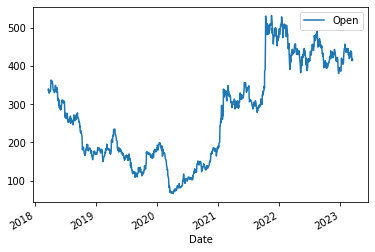

In [ ]:
opn.plot()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ds = opn.values

In [ ]:
ds

array([[335.5       ],
       [339.8999939 ],
       [338.5       ],
       ...,
       [413.29998779],
       [419.        ],
       [415.6000061 ]])

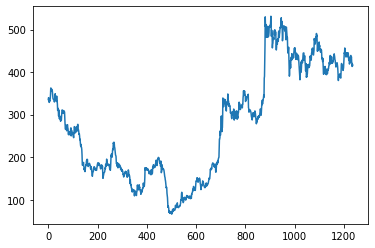

In [ ]:
plt.plot(ds)

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
len(ds_scaled), len(ds)

(1237, 1237)

In [ ]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
train_size,test_size

(865, 372)

In [ ]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [ ]:
len(ds_train),len(ds_test)

(865, 372)

In [ ]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
X_train.shape,y_train.shape

((764, 100), (764,))

In [ ]:
X_test.shape, y_test.shape

((271, 100), (271,))

In [ ]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 10s 301ms/step - loss: 0.0258 - val_loss: 0.0932
Epoch 2/100
12/12 [==============================] - 4s 393ms/step - loss: 0.0075 - val_loss: 0.0030
Epoch 3/100
12/12 [==============================] - 3s 196ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 4/100
12/12 [==============================] - 2s 191ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 5/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 6/100
12/12 [==============================] - 2s 192ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/100
12/12 [==============================] - 3s 291ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 8/100
12/12 [==============================] - 2s 194ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 9/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 10/100
12/12 [==============================] - 2s 192ms/step - loss: 0.0016 - val_l

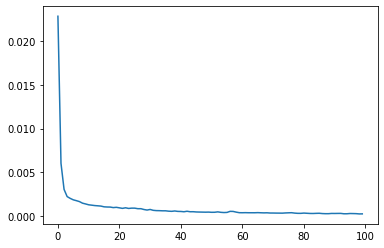

In [ ]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 34ms/step


In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

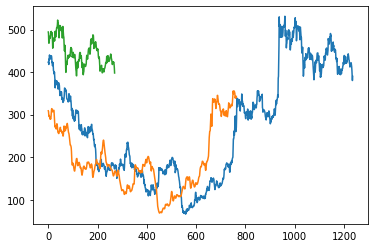

In [ ]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [ ]:
type(train_predict)

numpy.ndarray

In [ ]:
test = np.vstack((train_predict,test_predict))

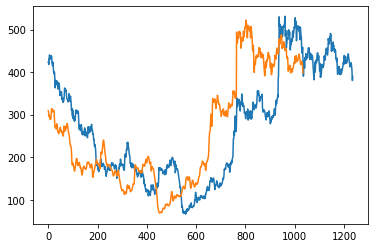

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [ ]:
len(ds_test)

371

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 101)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6981282234191895], [0.7072322368621826], [0.7155890464782715], [0.7233680486679077], [0.7301523089408875], [0.7357732653617859], [0.7403281331062317], [0.7440561056137085], [0.7472481727600098], [0.750182032585144], [0.7530810236930847], [0.7560951113700867], [0.7593001127243042], [0.7627100348472595], [0.7662935853004456], [0.7699958682060242], [0.7737517356872559], [0.7775018811225891], [0.7811986804008484], [0.7848100066184998], [0.788318932056427], [0.7917219996452332], [0.7950248718261719], [0.7982392907142639], [0.8013778328895569], [0.8044534921646118], [0.8074769377708435], [0.8104556798934937], [0.8133943676948547], [0.8162950277328491]]


In [ ]:
len(ds_scaled)

1236

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

1236

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

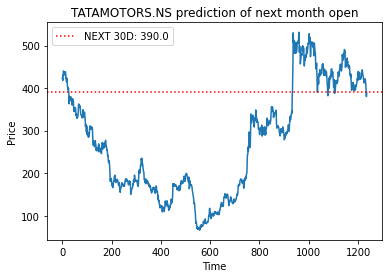

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

